##### Goals:
 *  Classify the review comments into Positive or Negative
 *  Sentiment Analysis
 

#### Data Preparation

In [1]:
import pandas as pd
import numpy as np
from bertopic import BERTopic
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
import seaborn as sns # Seaborn for visualizing. Note: we will also use one of the data sets
import matplotlib.pyplot as plt # Matplotlib for subplots
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler # Import for feature standardization
from sklearn.metrics import silhouette_samples, silhouette_score # For kmeans evaluation
from sklearn.datasets import load_wine # Used to pull in wine data

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
###Import Data 
### Note:  Data is in the zip. Extract it to the folder data
review_df=pd.read_csv("./data/amazon_reviews.csv")

In [ ]:
### Feature Name and Data Type in the Input Data
review_df.dtypes

asins                object
reviews.rating      float64
name                 object
brand                object
categories           object
reviews.text         object
reviews.title        object
reviews.username     object
dtype: object

In [ ]:
### Sample Data 
review_df.head(5)

,asins,reviews.rating,name,brand,categories,reviews.text,reviews.title,reviews.username
0,"B00QWO9P0O,B00LH3DMUO",3.0,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang
1,"B00QWO9P0O,B00LH3DMUO",4.0,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG
2,"B00QWO9P0O,B00LH3DMUO",5.0,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert
3,"B00QWO9P0O,B00LH3DMUO",5.0,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson
4,"B00QWO9P0O,B00LH3DMUO",5.0,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda


In [ ]:
#### Removed Nulls
review_df_cleaned=review_df[~review_df['reviews.text'].isnull()].copy()

In [ ]:
#Removed reviews with more than > 400 words  due to token limitation of Sentence Transformers and computing
review_df_cleaned['token_count'] = review_df_cleaned['reviews.text'].apply(lambda x: len(x.split()))
review_df_cleaned=review_df_cleaned[review_df_cleaned['token_count']<=400]

#### Visualization 

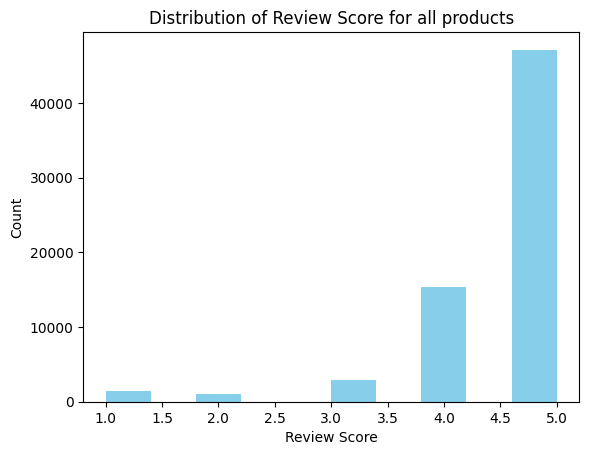

In [ ]:
plt.hist(review_df_cleaned['reviews.rating'],color='skyblue')
plt.xlabel('Review Score')
plt.ylabel('Count')
plt.title('Distribution of Review Score for all products')
plt.show()

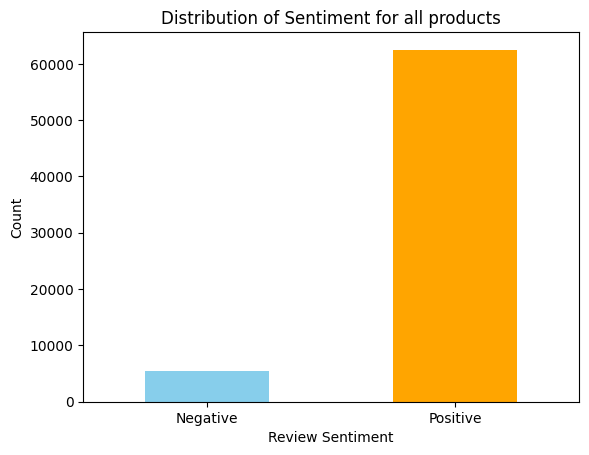

In [ ]:
review_df_cleaned['review_sentiment']=review_df_cleaned['reviews.rating']>3
# Count True/False
counts = review_df_cleaned['review_sentiment'].value_counts().sort_index() 

# Plot as bar chart
counts.plot(kind='bar', color=['skyblue', 'orange'])
plt.xticks(ticks=[0,1],rotation=0,labels=['Negative','Positive'])
plt.xlabel('Review Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiment from All reviews')
plt.show()

In [139]:
review_df_cleaned['reviews.text'].values.shape
docs = review_df_cleaned['reviews.text'].values
# Use a pre-trained BERT model for embeddings

### Classification (Supervised)
* Reviews converted into Text Embeddings and used as input feature
* Review Score is converted to Binary Feature. 
    * Review score > 3.0 is treated as Positive
    * Review score <= 3.0 is treated as Positive

In [ ]:
#### Generate Text Embeddings 
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(review_df_cleaned['reviews.text'].values)


In [150]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


X = embeddings
y = review_df_cleaned['review_sentiment']


# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


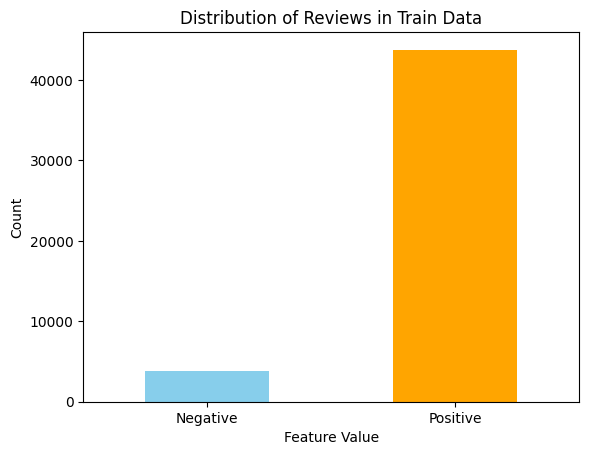

In [151]:
data = {'feature': y_train}
df = pd.DataFrame(data)

# Count True/False
counts = df['feature'].value_counts().sort_index()  # False comes first by default

# Plot as bar chart
counts.plot(kind='bar', color=['skyblue', 'orange'])
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'], rotation=0)
plt.xlabel('Feature Value')
plt.ylabel('Count')
plt.title('Distribution of Reviews in Train Data')
plt.show()

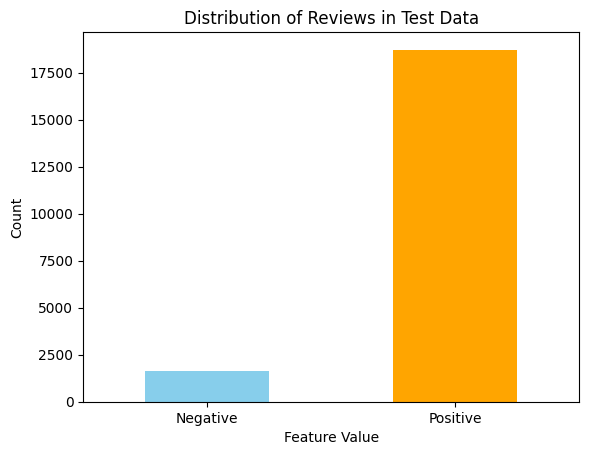

In [152]:
data = {'feature': y_test}
df = pd.DataFrame(data)

# Count True/False
counts = df['feature'].value_counts().sort_index()  # False comes first by default

# Plot as bar chart
counts.plot(kind='bar', color=['skyblue', 'orange'])
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'], rotation=0)
plt.xlabel('Feature Value')
plt.ylabel('Count')
plt.title('Distribution of Reviews in Test Data')
plt.show()

In [153]:

# Create and train logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict and print classification metrics
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       False       0.78      0.31      0.44      1659
        True       0.94      0.99      0.97     18723

    accuracy                           0.94     20382
   macro avg       0.86      0.65      0.70     20382
weighted avg       0.93      0.94      0.92     20382



In [138]:
import xgboost as xgb
# Create and train XGBoost classifier
model = xgb.XGBClassifier(use_label_encoder=False)
model.fit(X_train, y_train)

# Predict and print metrics
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.88      0.53      0.66      1659
        True       0.96      0.99      0.98     18723

    accuracy                           0.96     20382
   macro avg       0.92      0.76      0.82     20382
weighted avg       0.95      0.96      0.95     20382



* Oversampling using SMOTE to make the training set balanced

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

# Create and train XGBoost classifier
model = xgb.XGBClassifier(use_label_encoder=False)
model.fit(X_resampled, y_resampled)
print()

# Predict and print metrics
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.64      0.67      0.65      1659
        True       0.97      0.97      0.97     18723

    accuracy                           0.94     20382
   macro avg       0.80      0.82      0.81     20382
weighted avg       0.94      0.94      0.94     20382



In [161]:
review_df_cleaned['review_sentiment'].value_counts()

review_sentiment
True     62499
False     5441
Name: count, dtype: int64

In [162]:
import xgboost as xgb

# Compute scale_pos_weight = (# negative samples) / (# positive samples)
ratio=review_df_cleaned['review_sentiment'].value_counts()[1]/review_df_cleaned['review_sentiment'].value_counts()[0]
model = xgb.XGBClassifier(scale_pos_weight=ratio, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Predict and print metrics
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.69      0.66      0.68      1659
        True       0.97      0.97      0.97     18723

    accuracy                           0.95     20382
   macro avg       0.83      0.82      0.82     20382
weighted avg       0.95      0.95      0.95     20382



#### Observation
* Baseline Model: Logistic Regression 
    * A simple logistic regression shows the 94% precision , 99% recall and 97% F1 Score fore the Positive Reviews. 
    * The model has 78% precision , 31% recall and 44% F1 Score fore the Negative Reviews. 
* With same data XGBoost performs better. The model has 88% precision , 53% recall and 66% F1 Score fore the Negative Reviews. 

* Since the data is imbalanced, both models behaves better in Positive and not able to generalize. This can be improved by training the date with balanced data 

#### Classification (Unsupervised)

In [140]:
from transformers import pipeline

# Load sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

# Input text
texts = docs.tolist()

# Run sentiment analysis
results = sentiment_pipeline(texts)

# Print results
labels=[]
scores=[]
for result in results:
    labels.append(result['label'])
    scores.append(result['score'])


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [148]:
review_df_cleaned['Predicted']=[label=='POSITIVE' for label in labels]

In [149]:
from sklearn.metrics import classification_report
report = classification_report(review_df_cleaned['review_sentiment'], review_df_cleaned['Predicted'])
print(report)

              precision    recall  f1-score   support

       False       0.32      0.77      0.45      5441
        True       0.98      0.86      0.91     62499

    accuracy                           0.85     67940
   macro avg       0.65      0.81      0.68     67940
weighted avg       0.92      0.85      0.88     67940



#### Observation
* We used transformer pipeline ,which uses  DistilBert embeddings and classification for sentiment analysis. The reviews are classified as POSITIVE and NEGATIVE. 
* We compared the results of the classifier against the review score 
* The results show the unsupervised classification is in par to the baseline supervised classification with the 98% precision , 86% recall and 91% F1 Score fore the Positive Reviews. 
    * The model has 32% precision , 77% recall and 45% F1 Score fore the Negative Reviews. 
* The results can be improved with better model in higher embedding dimension